# Crisis Prediction in African Economies
Given data about financial climates in various African countries throughout the years, let's try to predict whether a banking crisis occurred or not in a given year in a given country.

We will use a TensorFlow ANN to make our predictions.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
data = pd.read_csv('/Users/shikarichacha/Desktop/GSsoC24/african_crises.csv')
data

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,DZA,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,1,DZA,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,1,DZA,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,1,DZA,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,1,DZA,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,70,ZWE,Zimbabwe,2009,1,354.800000,1,1,0.0,-7.670000,1,1,0,crisis
1055,70,ZWE,Zimbabwe,2010,0,378.200000,1,1,0.0,3.217000,1,0,0,no_crisis
1056,70,ZWE,Zimbabwe,2011,0,361.900000,1,1,0.0,4.920000,1,0,0,no_crisis
1057,70,ZWE,Zimbabwe,2012,0,361.900000,1,1,0.0,3.720000,1,0,0,no_crisis


In [24]:
# Cell 1: Interaction Terms
data['interaction_term'] = data['systemic_crisis'] * data['domestic_debt_in_default']

# Cell 2: Ratio Features
data['exchange_rate_inflation_ratio'] = data['exch_usd'] / data['inflation_annual_cpi']

# Cell 3: Moving Averages
data['gdp_weighted_default_ma'] = data['gdp_weighted_default'].rolling(window=3).mean()

# Cell 4: Difference Features
data['inflation_change'] = data['inflation_annual_cpi'].diff()

# Cell 5: Categorical Aggregations
cat_agg = data.groupby('banking_crisis')['inflation_annual_cpi'].mean().reset_index()
cat_agg.columns = ['banking_crisis', 'mean_inflation']
data = pd.merge(data, cat_agg, on='banking_crisis', how='left')


In [3]:
((data['banking_crisis'] == 'crisis').astype(int) == data['systemic_crisis']).all()

False

In [4]:
data.isna().sum()

case                               0
cc3                                0
country                            0
year                               0
systemic_crisis                    0
exch_usd                           0
domestic_debt_in_default           0
sovereign_external_debt_default    0
gdp_weighted_default               0
inflation_annual_cpi               0
independence                       0
currency_crises                    0
inflation_crises                   0
banking_crisis                     0
dtype: int64

In [5]:
data = data.drop(['case', 'country'], axis=1)

In [6]:
data

,cc3,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,DZA,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,DZA,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,DZA,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,DZA,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,DZA,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis
...,...,...,...,...,...,...,...,...,...,...,...,...
1054,ZWE,2009,1,354.800000,1,1,0.0,-7.670000,1,1,0,crisis
1055,ZWE,2010,0,378.200000,1,1,0.0,3.217000,1,0,0,no_crisis
1056,ZWE,2011,0,361.900000,1,1,0.0,4.920000,1,0,0,no_crisis
1057,ZWE,2012,0,361.900000,1,1,0.0,3.720000,1,0,0,no_crisis


In [7]:
cc3_dummies = pd.get_dummies(data['cc3'])
data = pd.concat([data, cc3_dummies], axis=1)
data = data.drop('cc3', axis=1)

In [8]:
data

,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,...,DZA,EGY,KEN,MAR,MUS,NGA,TUN,ZAF,ZMB,ZWE
0,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,...,True,False,False,False,False,False,False,False,False,False
1,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,...,True,False,False,False,False,False,False,False,False,False
2,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,...,True,False,False,False,False,False,False,False,False,False
3,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,...,True,False,False,False,False,False,False,False,False,False
4,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,2009,1,354.800000,1,1,0.0,-7.670000,1,1,0,...,False,False,False,False,False,False,False,False,False,True
1055,2010,0,378.200000,1,1,0.0,3.217000,1,0,0,...,False,False,False,False,False,False,False,False,False,True
1056,2011,0,361.900000,1,1,0.0,4.920000,1,0,0,...,False,False,False,False,False,False,False,False,False,True
1057,2012,0,361.900000,1,1,0.0,3.720000,1,0,0,...,False,False,False,False,False,False,False,False,False,True


In [9]:
y = data['banking_crisis']
X = data.drop('banking_crisis', axis=1)

In [10]:
y

0          crisis
1       no_crisis
2       no_crisis
3       no_crisis
4       no_crisis
          ...    
1054       crisis
1055    no_crisis
1056    no_crisis
1057    no_crisis
1058    no_crisis
Name: banking_crisis, Length: 1059, dtype: object

In [11]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)
{index: label for index, label in enumerate(label_encoder.classes_)}

{0: 'crisis', 1: 'no_crisis'}

In [12]:
y = pd.Series(y).apply(lambda x: 1 - x)
y

0       1
1       0
2       0
3       0
4       0
       ..
1054    1
1055    0
1056    0
1057    0
1058    0
Length: 1059, dtype: int64

In [13]:
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [14]:
X

,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,...,DZA,EGY,KEN,MAR,MUS,NGA,TUN,ZAF,ZMB,ZWE
0,-2.917150,3.451758,-0.386713,-0.203219,-0.424973,-0.147006,-0.030863,-1.862352,-0.378058,-0.385474,...,3.385088,-0.414078,-0.259885,-0.276079,-0.26195,-0.245072,-0.276079,-0.347325,-0.270089,-0.304761
1,-2.887313,-0.289707,-0.386708,-0.203219,-0.424973,-0.147006,-0.030848,-1.862352,-0.378058,-0.385474,...,3.385088,-0.414078,-0.259885,-0.276079,-0.26195,-0.245072,-0.276079,-0.347325,-0.270089,-0.304761
2,-2.857475,-0.289707,-0.386712,-0.203219,-0.424973,-0.147006,-0.030874,-1.862352,-0.378058,-0.385474,...,3.385088,-0.414078,-0.259885,-0.276079,-0.26195,-0.245072,-0.276079,-0.347325,-0.270089,-0.304761
3,-2.827638,-0.289707,-0.386718,-0.203219,-0.424973,-0.147006,-0.030852,-1.862352,-0.378058,-0.385474,...,3.385088,-0.414078,-0.259885,-0.276079,-0.26195,-0.245072,-0.276079,-0.347325,-0.270089,-0.304761
4,-2.797800,-0.289707,-0.386721,-0.203219,-0.424973,-0.147006,-0.030874,-1.862352,-0.378058,-0.385474,...,3.385088,-0.414078,-0.259885,-0.276079,-0.26195,-0.245072,-0.276079,-0.347325,-0.270089,-0.304761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,1.230271,3.451758,2.797088,4.920801,2.353091,-0.147006,-0.030880,0.536955,2.481682,-0.385474,...,-0.295413,-0.414078,-0.259885,-0.276079,-0.26195,-0.245072,-0.276079,-0.347325,-0.270089,3.281260
1055,1.260109,-0.289707,3.007099,4.920801,2.353091,-0.147006,-0.030864,0.536955,-0.378058,-0.385474,...,-0.295413,-0.414078,-0.259885,-0.276079,-0.26195,-0.245072,-0.276079,-0.347325,-0.270089,3.281260
1056,1.289946,-0.289707,2.860809,4.920801,2.353091,-0.147006,-0.030861,0.536955,-0.378058,-0.385474,...,-0.295413,-0.414078,-0.259885,-0.276079,-0.26195,-0.245072,-0.276079,-0.347325,-0.270089,3.281260
1057,1.319784,-0.289707,2.860809,4.920801,2.353091,-0.147006,-0.030863,0.536955,-0.378058,-0.385474,...,-0.295413,-0.414078,-0.259885,-0.276079,-0.26195,-0.245072,-0.276079,-0.347325,-0.270089,3.281260


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [16]:
X.shape

(1059, 23)

In [17]:
y.sum() / len(y)

0.08876298394711993

In [18]:
inputs = tf.keras.Input(shape=(23,))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name="auc")]
)


batch_size = 64
epochs = 60

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=0
)

In [19]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss"
)

fig.show()

In [20]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.0679 - auc: 0.9633


[0.06786259263753891, 0.9632835984230042]

In [21]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)



10/10 [==============================] - 0s 2ms/step


In [22]:
loss, auc = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, AUC: {auc}")


10/10 [==============================] - 0s 3ms/step - loss: 0.0679 - auc: 0.9633
Loss: 0.06786259263753891, AUC: 0.9632835984230042


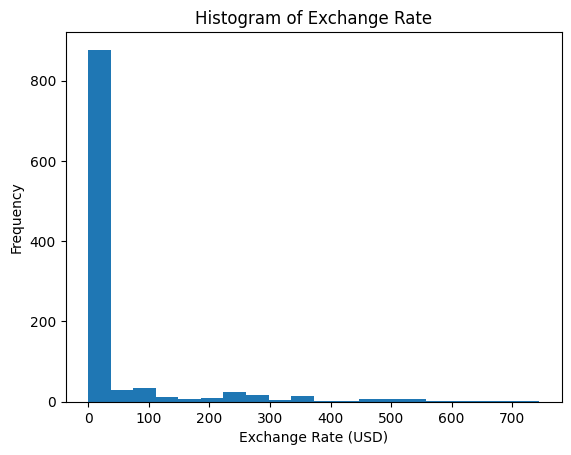

In [23]:
import matplotlib.pyplot as plt

plt.hist(data['exch_usd'], bins=20)
plt.xlabel('Exchange Rate (USD)')
plt.ylabel('Frequency')
plt.title('Histogram of Exchange Rate')
plt.show()
